In [3]:
# Imports
import geopandas as gpd
import numpy as np
import pandas as pd
import os 
import requests
import json
import datetime
import time
import random

# DATA PULL -------------------------------------------

### Census

In [2]:
k = "https://berkeley.zoom.us/j/94220849144?pwd=YWY3V0NRQmovcmlpVkcyMUppc2l1Zz09"
URL = f"https://api.census.gov/data/2017/ecnlocmfg?get=NAME,NAICS2017_LABEL,ESTAB&for=county:011&in=state:49&NAICS2017&key={k}"
response = requests.get(URL)
response.json()

### Tract Centers - Geopandas
I may want to add sensors nearby and weights

In [3]:
geojson_gdf = gpd.read_file('../static/data/converted_geojson_data.geojson')

#geojson_gdf['centroid'] = geojson_gdf.geometry.centroid

In [27]:
geojson_gdf.columns

Index(['OBJECTID', 'GEOID', 'Source', 'geoname', 'Stusab', 'Countyname',
       'State', 'County', 'Tract', 'BLKGRP', 'Low', 'Lowmod', 'Lmmi',
       'Lowmoduniv', 'Lowmod_pct', 'uclowmod', 'ucLowmod_p', 'MOE_LOWMOD_PCT',
       'MOE_UCLOWMOD_PCT', 'Shape__Area', 'Shape__Length', 'category',
       'geometry'],
      dtype='object')

In [13]:
geojson_gdf = geojson_gdf[['OBJECTID', 'GEOID','Countyname','Tract','Low','Lowmod','Lowmod_pct','centroid']]


In [21]:
# Function to categorize based on 'Lowmod_pct'
def categorize(lowmod_pct):
    if lowmod_pct > 0.75:
        return 'red'
    elif lowmod_pct > 0.5:
        return 'orange'
    elif lowmod_pct > 0.25:
        return 'green'
    else:
        return 'blue'

# Apply categorization
geojson_gdf['category'] = geojson_gdf['Lowmod_pct'].apply(categorize)





In [17]:
geojson_gdf.rename(columns = {'Countyname':'county'},inplace=True)
geojson_gdf['latitude'] = geojson_gdf['centroid'].apply(lambda geom: geom.y)
geojson_gdf['longitude'] = geojson_gdf['centroid'].apply(lambda geom: geom.x)

In [23]:
geojson_gdf.to_file('../static/data/centroids_data.geojson', driver='GeoJSON')

## Salt Lake County City Assets
Matched with tract centers
https://gis-slcgov.opendata.arcgis.com/


#### Traffic Lights

In [38]:
geojson_gdf = gpd.read_file('../static/data/converted_geojson_data.geojson')


url_intersection = 'Signalized_Intersection.geojson'
geojson_int = gpd.read_file(f'../static/data/ml/{url_intersection}')


In [39]:
geojson_int

,CARTID,OBJECTID,Ownership,Type,geometry
0,1,505154,Salt Lake City,Full Signal,"POLYGON ((-112.02506 40.77663, -112.02511 40.7..."
1,2,505155,Salt Lake City,Full Signal,"POLYGON ((-112.00572 40.77381, -112.00577 40.7..."
2,3,505156,Salt Lake City,Full Signal,"POLYGON ((-111.95820 40.76835, -111.95824 40.7..."
3,5,505157,Salt Lake City,Full Signal,"POLYGON ((-111.95315 40.77054, -111.95320 40.7..."
4,6,505158,Salt Lake City,Full Signal,"POLYGON ((-111.94696 40.77181, -111.94700 40.7..."
...,...,...,...,...,...
384,1911,505538,Airport,Full Signal,"POLYGON ((-111.98627 40.77368, -111.98631 40.7..."
385,1912,505539,Airport,Full Signal,"POLYGON ((-111.98442 40.78430, -111.98446 40.7..."
386,1913,505540,Airport,Full Signal,"POLYGON ((-111.98532 40.78422, -111.98536 40.7..."
387,1914,505541,Salt Lake City,HAWK,"POLYGON ((-111.89972 40.73681, -111.89976 40.7..."


In [215]:
if geojson_gdf.crs != geojson_int.crs:
    geojson_int = geojson_int.to_crs(geojson_gdf.crs)

# Step 2: Perform the spatial join
joined_geodata = gpd.sjoin(geojson_int, geojson_gdf, how="inner", op="within")

/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


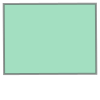

In [242]:
(joined_geodata['geometry'].values[130])

## Open-Mateo
https://open-meteo.com/en/docs/

In [3]:
# Must install the following

#!pip install openmeteo-requests
#!pip install requests-cache retry-requests numpy pandas

In [121]:
# Get Sensor lat and lon for Weather readings
dfx = pd.read_csv("../static/data/slc_daily_pm2.5_pm10_2016to2024.csv")
dfx = dfx.sort_values(['date'], ascending = False)

In [122]:
dfx=dfx.groupby(['sensor_id','latitude','longitude']).count().reset_index()[['latitude','longitude']]
dfx

,latitude,longitude
0,40.750816,-111.825290
1,41.224422,-111.968376
2,40.783870,-111.870140
3,40.595387,-111.807755
4,40.727630,-111.824425
...,...,...
217,40.593708,-111.895250
218,40.664610,-111.829270
219,40.567074,-111.988560
220,41.210533,-111.932014


In [7]:

dfx = pd.DataFrame({'latitude':[40.6442,41.2603,40.9629],'longitude':[111.9522,111.9522,112.0953]},\
             index=  ['Salt Lake County','Weber County','Davis County'])
dfx

,latitude,longitude
Salt Lake County,40.6442,111.9522
Weber County,41.2603,111.9522
Davis County,40.9629,112.0953


In [344]:
davis = 40.9629° N, 112.0953° W
weber = 41.2603° N, 111.9522° W
salt 40.6442° N, 111.9522° W

NameError: name 'wind_df' is not defined

In [9]:
dfx[0:3]

,latitude,longitude
Salt Lake County,40.6442,111.9522
Weber County,41.2603,111.9522
Davis County,40.9629,112.0953


In [34]:
dfx

,latitude,longitude
Salt Lake County,40.6442,111.9522
Weber County,41.2603,111.9522
Davis County,40.9629,112.0953


In [85]:
start_date = datetime.datetime.strptime("2021-01-01", '%Y-%m-%d')
end_date = start_date + datetime.timedelta(days=10)

#final_date = datetime.datetime.strptime("2024-03-20", '%Y-%m-%d')

url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": list(dfx.latitude.values),
    "longitude": list(dfx.longitude.values),
    "start_date": datetime.datetime.strftime(start_date, '%Y-%m-%d'),
    "end_date": datetime.datetime.strftime(start_date, '%Y-%m-%d'),
    "daily": ["wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant",],
    "temperature_unit": "fahrenheit",
    "wind_speed_unit": "mph",
    "timezone": "America/Denver"
}
responses = requests.get(url, params=params)
responses.json()


[{'latitude': 40.667835,
  'longitude': 111.92634,
  'generationtime_ms': 0.20301342010498047,
  'utc_offset_seconds': -21600,
  'timezone': 'America/Denver',
  'timezone_abbreviation': 'MDT',
  'elevation': 1105.0,
  'daily_units': {'time': 'iso8601',
   'wind_speed_10m_max': 'mp/h',
   'wind_gusts_10m_max': 'mp/h',
   'wind_direction_10m_dominant': '°'},
  'daily': {'time': ['2021-01-01'],
   'wind_speed_10m_max': [12.5],
   'wind_gusts_10m_max': [23.9],
   'wind_direction_10m_dominant': [235]}},
 {'latitude': 41.23023,
  'longitude': 111.91977,
  'generationtime_ms': 0.0959634780883789,
  'utc_offset_seconds': -21600,
  'timezone': 'America/Denver',
  'timezone_abbreviation': 'MDT',
  'elevation': 2004.0,
  'location_id': 1,
  'daily_units': {'time': 'iso8601',
   'wind_speed_10m_max': 'mp/h',
   'wind_gusts_10m_max': 'mp/h',
   'wind_direction_10m_dominant': '°'},
  'daily': {'time': ['2021-01-01'],
   'wind_speed_10m_max': [19.2],
   'wind_gusts_10m_max': [41.4],
   'wind_directio

In [87]:
for response in responses:
    print (response)

b'[{"latitude":40.667835,"longitude":111.92634,"generationtime_ms":0.20301342010498047,"utc_offset_seconds":-21600,"timezone":"Ame'
b'rica/Denver","timezone_abbreviation":"MDT","elevation":1105.0,"daily_units":{"time":"iso8601","wind_speed_10m_max":"mp/h","wind_'
b'gusts_10m_max":"mp/h","wind_direction_10m_dominant":"\xc2\xb0"},"daily":{"time":["2021-01-01"],"wind_speed_10m_max":[12.5],"wind_gusts'
b'_10m_max":[23.9],"wind_direction_10m_dominant":[235]}},{"latitude":41.23023,"longitude":111.91977,"generationtime_ms":0.09596347'
b'80883789,"utc_offset_seconds":-21600,"timezone":"America/Denver","timezone_abbreviation":"MDT","elevation":2004.0,"location_id":'
b'1,"daily_units":{"time":"iso8601","wind_speed_10m_max":"mp/h","wind_gusts_10m_max":"mp/h","wind_direction_10m_dominant":"\xc2\xb0"},"d'
b'aily":{"time":["2021-01-01"],"wind_speed_10m_max":[19.2],"wind_gusts_10m_max":[41.4],"wind_direction_10m_dominant":[292]}},{"lat'
b'itude":40.94903,"longitude":111.92308,"generationtime_ms":0.07

In [75]:
#I really only needed wind for the actual sensor location for historic

# I want to modify this to just get. specific latitudes and longitudes instead of my grid method

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
start_date = datetime.datetime.strptime("2021-01-01", '%Y-%m-%d')
end_date = start_date + datetime.timedelta(days=10)

final_date = datetime.datetime.strptime("2024-03-20", '%Y-%m-%d')

i=0

while start_date < final_date:
    print(start_date)
    for i in range(0,3,3):

        url = "https://archive-api.open-meteo.com/v1/archive"

        params = {
            "latitude": list(dfx.iloc[i:i+3].latitude),
            "longitude": list(dfx.iloc[i:i+3].longitude),
            "start_date": datetime.datetime.strftime(start_date, '%Y-%m-%d'),
            "end_date": datetime.datetime.strftime(end_date, '%Y-%m-%d'),
            "daily": ["wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant",],
            "temperature_unit": "fahrenheit",
            "wind_speed_unit": "mph",
            "timezone": "America/Denver"
        }
        responses = requests.get(url, params=params)
        print(responses.status_code)

        temp_df_b = pd.DataFrame()
        
        
        for response in responses.json():
    
            temp_df = pd.DataFrame(response['daily'])
            temp_df['latitiude'] = response['latitude']
            temp_df['longitude'] = response['longitude']
            temp_df.drop_duplicates(subset=['wind_speed_10m_max',\
                                            'wind_gusts_10m_max',\
                                            'wind_direction_10m_dominant'], keep='first',inplace = True)

            temp_df_b = pd.concat([temp_df_b,temp_df],ignore_index=True)

        wind_df = pd.concat([wind_df,temp_df_b],ignore_index=True)
        time.sleep(2+random.random())
    
    time.sleep(2.9+random.random())
    start_date += datetime.timedelta(days=11)
    end_date = start_date + datetime.timedelta(days=10)
    

2021-01-01 00:00:00
200
2021-01-12 00:00:00
200
2021-01-23 00:00:00
200
2021-02-03 00:00:00
200
2021-02-14 00:00:00
200
2021-02-25 00:00:00
200
2021-03-08 00:00:00
200
2021-03-19 00:00:00
200
2021-03-30 00:00:00
200
2021-04-10 00:00:00
200
2021-04-21 00:00:00
200
2021-05-02 00:00:00
200
2021-05-13 00:00:00
200
2021-05-24 00:00:00
200
2021-06-04 00:00:00
200
2021-06-15 00:00:00
200
2021-06-26 00:00:00
200
2021-07-07 00:00:00
200
2021-07-18 00:00:00
200
2021-07-29 00:00:00
200
2021-08-09 00:00:00
200
2021-08-20 00:00:00
200
2021-08-31 00:00:00
200
2021-09-11 00:00:00
200
2021-09-22 00:00:00
200
2021-10-03 00:00:00
200
2021-10-14 00:00:00
200
2021-10-25 00:00:00
200
2021-11-05 00:00:00
200
2021-11-16 00:00:00
200
2021-11-27 00:00:00
200
2021-12-08 00:00:00
200
2021-12-19 00:00:00
200
2021-12-30 00:00:00
200
2022-01-10 00:00:00
200
2022-01-21 00:00:00
200
2022-02-01 00:00:00
200
2022-02-12 00:00:00
200
2022-02-23 00:00:00
200
2022-03-06 00:00:00
200
2022-03-17 00:00:00
200
2022-03-28 00:00

In [79]:
wind_df.loc[wind_df.time == '2021-01-01']
wind_df.to_csv('../static/data/wind_by_county.csv')

In [69]:
wind_df.loc[wind_df.time=='2022-10-14']
dfx

,time,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,latitiude,longitude
0,2022-10-14,12.2,23.0,221,40.667835,111.92634
11,2022-10-14,14.7,31.1,266,41.230230,111.91977
22,2022-10-14,13.2,25.9,191,40.949030,111.92308


In [70]:
dfx

,latitude,longitude
Salt Lake County,40.6442,111.9522
Weber County,41.2603,111.9522
Davis County,40.9629,112.0953


In [166]:
#wind_df.drop_duplicates(inplace=True)
print(f'length before drop: {len(df_wind_2021_2023)}')
df_wind_2021_2023.drop_duplicates(keep='first',inplace = True)
print(f'length before drop: {len(df_wind_2021_2023)}')

length before drop: 292248
length before drop: 227760


In [167]:
df_wind_2021_2023.rename(columns={'latitiude':'latitude'}, inplace=True)
df_wind_2021_2023.sort_values(['time','latitude','longitude'],inplace=True)

In [172]:
df_wind_2021_2023='' #clear
wind_df_A_2020 = ''
wind_df_B_2021 = ''
wind_df_C_2021 =''
wind_df_E_2022 = ''

#df_wind_2021_2023.to_csv('../static/data/df_wind_2021_2023.csv')

In [345]:
#df_wind['ll']=df_wind['latitude']+df_wind['longitude']
len(df_wind_2021_2023.latitude.unique())

NameError: name 'df_wind_2021_2023' is not defined

# LOAD DATA --------------------------------------------------

### Weather Data

In [346]:
df_wind = pd.read_csv('../static/data/df_wind_2021_2023.csv') 
#pd.to_datetime(date_string)
df_wind['date'] = pd.to_datetime(df_wind['time'])

In [349]:
df_purple.latitude.unique()

array([41.15395 , 40.6398  , 41.06316 , 40.574078, 41.0665  , 40.779472,
       40.78668 , 40.675575, 40.691936, 40.942867, 40.744972, 41.224422,
       41.07105 , 40.735126, 41.088875, 40.637936, 40.701218, 40.710594,
       40.665512, 40.68405 , 40.68914 , 40.68262 , 40.65524 , 40.67845 ,
       40.733875, 40.769947, 40.77445 , 41.06097 , 40.908325, 40.90276 ,
       41.321125, 41.100193, 40.689068, 40.792244, 40.710438, 40.84942 ,
       40.694   , 41.02446 , 40.84746 , 41.087585, 40.68852 , 40.709763,
       40.62173 , 40.57964 , 40.703495, 40.609367, 40.766937, 40.67708 ,
       40.656242, 40.629227, 40.74412 , 40.71572 , 40.581345, 40.61586 ,
       40.65376 , 40.674072, 40.73344 , 40.72031 , 40.899494, 40.68566 ,
       41.10572 , 40.785297, 40.682564, 41.19397 , 40.773415, 40.674377,
       40.70351 , 40.696323, 40.796906, 40.611156, 40.703976, 40.677616,
       40.68181 , 41.06404 , 40.77824 , 40.67275 , 40.78727 , 40.751663,
       40.74115 , 40.74831 , 40.67895 , 40.681103, 

In [121]:
# get geopandas tract
# Convert df_purple to a GeoDataFrame
gdf_wind = gpd.GeoDataFrame(
    df_wind, 
    geometry=gpd.points_from_xy(df_wind.longitude, df_wind.latitude),
    crs="EPSG:4326" # Assuming the coordinates are in WGS84
)

### Purple Air

In [4]:
df_purple = pd.read_csv("../static/data/slc_daily_pm2.5_pm10_2016to2024.csv")
df_purple = df_purple.sort_values(['date'], ascending = False)

In [5]:
df_purple = df_purple[['sensor_id','latitude','longitude','date','altitude','pm2.5_atm','pm10.0_atm']]
df_purple.rename(columns = {'pm2.5_atm':'pm2','pm10.0_atm':'pm10'},inplace=True)
df_purple['date'] = pd.to_datetime(df_purple['date'], format='%m/%d/%y')
df_purple['month'] = df_purple['date'].dt.month
df_purple.head()


,sensor_id,latitude,longitude,date,altitude,pm2,pm10,month
232809,83563,41.153950,-111.937020,2023-09-09,4806,2.0930,2.3085,9
243366,122011,40.639800,-111.822510,2023-09-09,4499,0.4095,0.5130,9
241621,114467,41.063160,-111.903320,2023-09-09,5104,0.1460,0.2130,9
225969,44157,40.574078,-111.958800,2023-09-09,4533,10.7160,12.9255,9
217892,30967,41.066500,-111.912445,2023-09-09,4774,3.4305,3.9045,9


In [124]:
len(df_purple)

265676

In [6]:
df_purple = df_purple.loc[df_purple.date >= '2020-01-01']
df_purple.head()

,sensor_id,latitude,longitude,date,altitude,pm2,pm10,month
232809,83563,41.153950,-111.937020,2023-09-09,4806,2.0930,2.3085,9
243366,122011,40.639800,-111.822510,2023-09-09,4499,0.4095,0.5130,9
241621,114467,41.063160,-111.903320,2023-09-09,5104,0.1460,0.2130,9
225969,44157,40.574078,-111.958800,2023-09-09,4533,10.7160,12.9255,9
217892,30967,41.066500,-111.912445,2023-09-09,4774,3.4305,3.9045,9


In [8]:
# Convert df_purple to a GeoDataFrame
gdf_purple = gpd.GeoDataFrame(
    df_purple, 
    geometry=gpd.points_from_xy(df_purple.longitude, df_purple.latitude),
    crs="EPSG:4326" # Assuming the coordinates are in WGS84
)

In [9]:
# join df_purple and wind_df
# Perform a spatial join
joined_gdf = gpd.sjoin(gdf_purple, geojson_gdf, how="inner", op="within")


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
joined_gdf.columns

Index(['sensor_id', 'latitude', 'longitude', 'date', 'altitude', 'pm2', 'pm10',
       'month', 'geometry', 'index_right', 'OBJECTID', 'GEOID', 'Source',
       'geoname', 'Stusab', 'Countyname', 'State', 'County', 'Tract', 'BLKGRP',
       'Low', 'Lowmod', 'Lmmi', 'Lowmoduniv', 'Lowmod_pct', 'uclowmod',
       'ucLowmod_p', 'MOE_LOWMOD_PCT', 'MOE_UCLOWMOD_PCT', 'Shape__Area',
       'Shape__Length', 'category'],
      dtype='object')

In [164]:
joined_gdf_wind = gpd.sjoin(gdf_wind, geojson_gdf, how="inner", op="within")

/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [165]:
joined_gdf_wind.columns

#keep:

#rid:
'GEOID', 'Source', 'geoname', 'Stusab', 'Countyname',
       'State', 'County', 'Tract', 'BLKGRP', 'Low', 'Lowmod', 'Lmmi',
       'Lowmoduniv', 'Lowmod_pct', 'uclowmod', 'ucLowmod_p', 'MOE_LOWMOD_PCT',
       'MOE_UCLOWMOD_PCT', 'Shape__Area', 'Shape__Length', 'category','time','OBJECTID'

IndentationError: unexpected indent (3546985711.py, line 7)

In [166]:
joined_gdf_wind = joined_gdf_wind[['date','Unnamed: 0', 'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'weather_code', 'temperature_2m_max',
       'temperature_2m_min', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
       'latitude', 'longitude', 'elevation','geometry','Tract']]

In [133]:
joined_gdf_wind['month'] = joined_gdf_wind['date'].dt.month

In [136]:
joined_gdf_wind.rename(columns = {'Unnamed: 0':'sensor_index'}, inplace=True)
joined_gdf_wind.reset_index()
# joined_gdf_wind = joined_gdf_wind.drop('index', axis=1)
joined_gdf_wind.head()

,date,sensor_id,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,weather_code,temperature_2m_max,temperature_2m_min,rain_sum,snowfall_sum,precipitation_hours,latitude,longitude,elevation,geometry,Tract,month
0,2021-01-01,143,7.5,17.7,110,3,28.9,15.8,0.0,0.0,0.0,40.527240,-111.864395,1488.0,POINT (-111.86440 40.52724),112823,1
1,2021-01-01,506,8.7,12.8,301,1,29.9,12.9,0.0,0.0,0.0,40.597538,-112.022630,1519.0,POINT (-112.02263 40.59754),114300,1
2,2021-01-01,1628,8.7,12.8,301,1,30.6,13.6,0.0,0.0,0.0,40.597538,-112.022630,1454.0,POINT (-112.02263 40.59754),114300,1
3,2021-01-01,1749,8.7,12.8,301,1,31.0,14.0,0.0,0.0,0.0,40.597538,-112.022630,1419.0,POINT (-112.02263 40.59754),114300,1
4,2021-01-01,2310,8.7,12.8,301,1,30.5,13.5,0.0,0.0,0.0,40.597538,-112.022630,1468.0,POINT (-112.02263 40.59754),114300,1


In [11]:
joined_gdf_final = joined_gdf_wind.merge(joined_gdf[['County','Tract','sensor_id','date','pm2','pm10','category','altitude','latitude','longitude']]\
                                                    , on=['date','Tract'])
#joined_gdf.loc[joined_gdf.sensor_id == 908]

NameError: name 'joined_gdf_wind' is not defined

In [175]:
joined_gdf_final = joined_gdf_final.drop('Unnamed: 0', axis=1)
joined_gdf_final.columns

Index(['date', 'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'weather_code', 'temperature_2m_max',
       'temperature_2m_min', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
       'latitude_x', 'longitude_x', 'elevation', 'geometry', 'Tract', 'County',
       'sensor_id', 'pm2', 'pm10', 'category', 'altitude', 'latitude_y',
       'longitude_y'],
      dtype='object')

In [12]:
avg_pm = joined_gdf.groupby(['County', 'date'])[['pm2', 'pm10']].mean().reset_index()
avg_pm.columns = ['County', 'date', 'avg_pm2', 'avg_pm10']


In [13]:
# Ensure that the 'date' column in both DataFrames are of the same type, preferably datetime64
joined_gdf['date'] = pd.to_datetime(joined_gdf['date'])
avg_pm['date'] = pd.to_datetime(avg_pm['date'])

# Merging the average values back to the original GeoDataFrame
joined_gdf_finalx = joined_gdf.merge(avg_pm, on=['County', 'date'], how='left')


In [14]:
joined_gdf_finalx.latitude.unique()

array([41.15395 , 40.6398  , 41.06316 , 40.574078, 41.0665  , 40.779472,
       40.78668 , 40.675575, 40.691936, 40.942867, 40.744972, 41.224422,
       41.07105 , 40.735126, 41.088875, 40.637936, 40.701218, 40.710594,
       40.665512, 40.68405 , 40.68914 , 40.68262 , 40.65524 , 40.67845 ,
       40.733875, 40.769947, 40.77445 , 41.06097 , 40.908325, 40.90276 ,
       41.321125, 41.100193, 40.689068, 40.792244, 40.710438, 40.84942 ,
       40.694   , 41.02446 , 40.84746 , 41.087585, 40.68852 , 40.709763,
       40.62173 , 40.57964 , 40.703495, 40.609367, 40.766937, 40.67708 ,
       40.656242, 40.629227, 40.74412 , 40.71572 , 40.581345, 40.61586 ,
       40.65376 , 40.674072, 40.73344 , 40.72031 , 40.899494, 40.68566 ,
       41.10572 , 40.785297, 40.682564, 41.19397 , 40.773415, 40.674377,
       40.70351 , 40.696323, 40.796906, 40.611156, 40.703976, 40.677616,
       40.68181 , 41.06404 , 40.77824 , 40.67275 , 40.78727 , 40.751663,
       40.74115 , 40.74831 , 40.67895 , 40.681103, 

In [193]:
#Calculate averages for wind_speed and wind_gusts
avg_wind = joined_gdf_final_with_avg.groupby(['Tract', 'date'])[['wind_speed_10m_max', 'wind_gusts_10m_max','wind_direction_10m_dominant']].mean().reset_index()


In [195]:
# Ensure 'date' is of datetime type in both DataFrames
joined_gdf_final_with_avg['date'] = pd.to_datetime(joined_gdf_final_with_avg['date'])
avg_wind['date'] = pd.to_datetime(avg_wind['date'])

# Merging the average wind statistics back to the original GeoDataFrame
joined_gdf_final_with_wind_avg = joined_gdf_final_with_avg.merge(avg_wind, on=['Tract', 'date'], how='left')


In [196]:
joined_gdf_final_with_wind_avg['latitude_x'].unique()

Index(['date', 'wind_speed_10m_max_x', 'wind_gusts_10m_max_x',
       'wind_direction_10m_dominant_x', 'weather_code', 'temperature_2m_max',
       'temperature_2m_min', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
       'latitude_x', 'longitude_x', 'elevation', 'geometry', 'Tract', 'County',
       'sensor_id', 'pm2', 'pm10', 'category', 'altitude', 'latitude_y',
       'longitude_y', 'avg_pm2', 'avg_pm10', 'wind_speed_10m_max_y',
       'wind_gusts_10m_max_y', 'wind_direction_10m_dominant_y'],
      dtype='object')

In [261]:
joined_gdf_final_with_wind_avg['month'] = joined_gdf_final_with_wind_avg['date'].dt.month

# standardize:
# wind_speed_10m_max_y,wind_gusts_10m_max_y,wind_direction_10m_dominant_y, weather_code, temperature_2m_max, temperature_2m_min,elevation,latitude_y,longitude_y
# avg_pm2, avg_pm10
# # #one-hot encoding:
# # weather_code,category,county

In [295]:
joined_gdf_final_with_wind_avg = joined_gdf_final_with_wind_avg.loc[joined_gdf_final_with_wind_avg.pm2<200]

In [15]:
from sklearn.preprocessing import LabelEncoder

# Creating label encoder object
le = LabelEncoder()

# Applying label encoding to 'County'
joined_gdf_finalx['County_encoded'] = le.fit_transform(joined_gdf_finalx['County'])

# Applying label encoding to 'category'
joined_gdf_finalx['category_encoded'] = le.fit_transform(joined_gdf_finalx['category'])

In [246]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp_test
X_train, X_temp_test, y_train, y_temp_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split of temp_test: 2/3 validation, 1/3 test => 20% of original data validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp_test, y_temp_test, test_size=1/3, random_state=42)

# Now you have:
# X_train, y_train: 70% of the data
# X_val, y_val: 20% of the data
# X_test, y_test: 10% of the data


In [253]:
joined_gdf_final_with_wind_avg['category_encoded']

0         1
1         2
2         1
3         2
4         1
         ..
101199    0
101200    1
101201    1
101202    1
101203    1
Name: category_encoded, Length: 101204, dtype: int64

### Prepare Data

In [1]:
df = df.loc[df.pm2<200]

NameError: name 'df' is not defined

In [297]:
X = joined_gdf_final_with_wind_avg[['wind_speed_10m_max_y','wind_gusts_10m_max_y','wind_direction_10m_dominant_y',\
    'weather_code', 'temperature_2m_max', 'temperature_2m_min','elevation','latitude_y','longitude_y',\
                                    'avg_pm2','avg_pm10','month','category_encoded','County_encoded']]
# Replace 'target_column' with your actual target column name
y = joined_gdf_final_with_wind_avg['pm2']  # Target variable


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [299]:
# Columns to standardize
standardize_cols = ['wind_speed_10m_max_y','wind_gusts_10m_max_y','wind_direction_10m_dominant_y',\
    'weather_code', 'temperature_2m_max', 'temperature_2m_min','elevation','latitude_y','longitude_y',\
                                    'avg_pm2','avg_pm10','month']

# Columns to one-hot encode
encode_cols = ['we, 'category_encoded', 'County_encoded','month']  # Ensure 'County' is the correct column name for your dataset


In [17]:
X = joined_gdf_finalx[['latitude','longitude',\
                                    'avg_pm2','avg_pm10','month','category_encoded','County_encoded']]
# Replace 'target_column' with your actual target column name
y = joined_gdf_finalx['pm2']  # Target variable

In [18]:
joined_gdf_finalx = joined_gdf_finalx.loc[joined_gdf_finalx.pm2<200]

In [19]:
# Columns to standardi
standardize_cols = ['latitude','longitude',\
                                    'avg_pm2']

# Columns to one-hot encode
encode_cols = ['category_encoded', 'County_encoded','month']  # Ensure 'County' is the correct column name for your dataset


In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), standardize_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), encode_cols)
    ])

In [361]:
X.longitude_x

AttributeError: 'DataFrame' object has no attribute 'longitude_x'

In [21]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp_test
X_train, X_temp_test, y_train, y_temp_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Second split of temp_test: 2/3 validation, 1/3 test => 20% of original data validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp_test, y_temp_test, test_size=1/2, random_state=42)

# Now you have:
# X_train, y_train: 70% of the data
# X_val, y_val: 20% of the data
# X_test, y_test: 10% of the data

In [22]:
X_

NameError: name 'X_' is not defined

In [23]:
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the validation and test data
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# MODEL - TENSORFLOW -------------------------------

In [387]:
y

0          2.0930
1          0.4095
2          0.1460
3         10.7160
4          3.4305
           ...   
228088    20.9930
228089    16.9310
228090    21.1315
228091    28.0945
228092    26.1635
Name: pm2, Length: 228093, dtype: float64

In [24]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [25]:
# set randomizer seeds

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
import matplotlib.pyplot as plt

In [26]:
import numpy as np

# Applying log1p transformation
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)


In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Assuming X_train_transformed is your training feature set
input_shape = (X_train_transformed.shape[1],)  # Dynamically set input shape

inputs = Input(shape=input_shape)

# Creating a simple dense network
x = Dense(32, activation='relu')(inputs)
x1 = Dense(16, activation='relu')(x)
# x2 = Dense(32, activation='relu')(x1)
outputs = Dense(1, activation='linear')(x1)  # Assuming a regression problem; adjust if it's classification

# Create the model
model3 = Model(inputs=inputs, outputs=outputs)

# Compile the model with adjustable learning rate
learning_rate = 0.01  # Placeholder for learning rate
optimizer = Adam(learning_rate=learning_rate)
model3.compile(optimizer=optimizer,
              loss='mean_squared_error',  # Use 'categorical_crossentropy' for multi-class classification,
                                           # 'binary_crossentropy' for binary classification
              metrics=['accuracy'])  # Or another metric suitable for your problem

model3.summary()

# Placeholder for epochs
epochs = 50  # Adjust the number of epochs

# Training the model with the training data and validating using the validation set
history = model3.fit(X_train_transformed, y_train_log,
                    validation_data=(X_val_transformed, y_val_log),
                    epochs=epochs,
                    batch_size=32)  # Adjust batch size as necessary


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 3s 537us/step - accuracy: 0.0000e+00 - loss: 1.7883 - val_accuracy: 0.0000e+00 - val_loss: 1.6086
Epoch 2/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 515us/step - accuracy: 0.0000e+00 - loss: 1.5939 - val_accuracy: 0.0000e+00 - val_loss: 1.5318
Epoch 3/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 519us/step - accuracy: 0.0000e+00 - loss: 1.4929 - val_accuracy: 0.0000e+00 - val_loss: 1.4634
Epoch 4/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 513us/step - accuracy: 2.2346e-05 - loss: 1.4230 - val_accuracy: 0.0000e+00 - val_loss: 1.4057
Epoch 5/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 518us/step - accuracy: 2.8166e-05 - loss: 1.3869 - val_accuracy: 6.5762e-05 - val_loss: 1.3910
Epoch 6/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 516us/step - accuracy: 9.2881e-06 - loss: 1.3618 - val_accuracy: 6.5762e-05 - val_loss: 1.3651
Epoch 7/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 519us/step - accuracy: 3.5220e-05 - loss: 1.3460 - val_accuracy: 0.0000e+00 - val_loss: 1.3980
Epoch 8/50
4277/4277

Epoch 48/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 512us/step - accuracy: 0.0000e+00 - loss: 1.1436 - val_accuracy: 0.0000e+00 - val_loss: 1.1767
Epoch 49/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 511us/step - accuracy: 0.0000e+00 - loss: 1.1367 - val_accuracy: 0.0000e+00 - val_loss: 1.2305
Epoch 50/50
4277/4277 ━━━━━━━━━━━━━━━━━━━━ 2s 512us/step - accuracy: 0.0000e+00 - loss: 1.1356 - val_accuracy: 0.0000e+00 - val_loss: 1.3000


In [2]:
# import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])


NameError: name 'plt' is not defined

In [327]:
y_test_pred = model2.predict(X_test_transformed)
y_pred_original = np.expm1(y_test_pred)


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


In [325]:
y_pred_original

array([[ 0.9778535 ],
       [ 2.3288798 ],
       [ 1.5116867 ],
       [ 2.0389276 ],
       [ 5.5892634 ],
       [ 7.588307  ],
       [ 1.7155124 ],
       [ 2.203684  ],
       [16.367409  ],
       [10.838398  ],
       [ 3.814579  ],
       [13.957528  ],
       [ 2.649971  ],
       [ 3.158389  ],
       [ 4.732889  ],
       [ 5.8700585 ],
       [ 4.77809   ],
       [ 3.9799988 ],
       [ 3.4867353 ],
       [ 1.391469  ],
       [ 5.1523376 ],
       [ 2.0494795 ],
       [ 1.4748871 ],
       [ 1.149082  ],
       [13.410356  ],
       [34.382156  ],
       [ 4.249869  ],
       [ 3.2707949 ],
       [11.640501  ],
       [ 2.4422717 ],
       [ 1.549645  ],
       [ 4.156542  ],
       [ 7.483847  ],
       [ 5.4928327 ],
       [ 2.3614318 ],
       [ 2.7597058 ],
       [ 3.2645898 ],
       [ 1.6259712 ],
       [ 2.341651  ],
       [ 5.575136  ],
       [17.523249  ],
       [ 9.396352  ],
       [ 2.501612  ],
       [ 3.9797506 ],
       [16.776972  ],
       [11

In [384]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_original))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_original))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred_original, squared=False))
print("R-squared Score:", r2_score(y_test, y_pred_original))


ValueError: Found input variables with inconsistent numbers of samples: [22810, 9821]

In [319]:
model.save('../static/data/test_model.h5')


In [28]:
keras.saving.save_model(model, '../static/data/test_model.keras')